In [1]:
import torch
device = torch.device("cpu")
print("Device is set to", device)

Device is set to cpu


# Load SQuAD 1.1 dataset

In [2]:
from model.data import SQuAD
data = SQuAD(device=device, train_batch_size=1, dev_batch_size=1)
print("SQuAD 1.1 loaded")

SQuAD 1.1 loaded


# Load trained BiDAF model

In [3]:
model_time = "1554992975"  # TODO

In [4]:
from model.model import BiDAF
model = BiDAF(pretrain_embedding=data.WORD.vocab.vectors,
              char_vocab_size=len(data.CHAR_NESTING.vocab)).to(device)

model.load_state_dict(torch.load(f'trained_models/BiDAF_{model_time}.pt', map_location='cpu'))
model.eval()

BiDAF(
  (char_emb): CharCNN(
    (char_embedding): Embedding(1318, 8)
    (char_cnn): Conv2d(1, 100, kernel_size=(5, 8), stride=(1, 1))
    (dropout): Dropout(p=0.2)
  )
  (word_emb): Embedding(97385, 100)
  (highway): HighwayMLP(
    (gate): ModuleList(
      (0): Sequential(
        (0): Linear(in_features=200, out_features=200, bias=True)
        (1): Sigmoid()
      )
      (1): Sequential(
        (0): Linear(in_features=200, out_features=200, bias=True)
        (1): Sigmoid()
      )
    )
    (transform): ModuleList(
      (0): Sequential(
        (0): Linear(in_features=200, out_features=200, bias=True)
        (1): ReLU()
      )
      (1): Sequential(
        (0): Linear(in_features=200, out_features=200, bias=True)
        (1): ReLU()
      )
    )
  )
  (contextual_emb): SingleLayerLSTM(
    (lstm): LSTM(200, 100, batch_first=True, bidirectional=True)
    (dropout): Dropout(p=0.2)
  )
  (ws_h): Linear(
    (linear): Linear(in_features=200, out_features=1, bias=True)
    (d

# Pull out model forward logic to get intermediate variables

In [6]:
qa_id = "56be4e1facb8001400a502fa"
for b in iter(data.dev_iter):
    if b.id[0] == qa_id:
        batch = b
        break

In [7]:
# Character Embedding Layer
x_char_emb = model.char_emb(batch.x_char)
q_char_emb = model.char_emb(batch.q_char)
# Word Embedding Layer
x_word_emb = model.word_emb(batch.x_word[0])
q_word_emb = model.word_emb(batch.q_word[0])
x_lens = batch.x_word[1]
q_lens = batch.q_word[1]
x = model.highway(x_char_emb, x_word_emb)
q = model.highway(q_char_emb, q_word_emb)
# Contextual Embedding Layer
h = model.contextual_emb(x, x_lens)
u = model.contextual_emb(q, q_lens)

In [8]:
# Attention Flow Layer
t = h.size(1)  # x_len, h: (batch, x_len, hidden*2)
j = u.size(1)  # q_len, u: (batch, q_len, hidden*2)
hh = h.unsqueeze(2).expand(-1, -1, j, -1)  # (batch, x_len, q_len, hidden*2)
uu = u.unsqueeze(1).expand(-1, t, -1, -1)  # (batch, x_len, q_len, hidden*2)
s = model.ws_h(hh) + model.ws_u(uu) + model.ws_hu(hh * uu)  # (batch, x_len, q_len)
s = s.squeeze(dim=-1)

a = torch.nn.functional.softmax(s, dim=-1)     # (batch, x_len, q_len)
c2q_att = torch.bmm(a, u)   # (batch, x_len, hidden*2)

b = torch.nn.functional.softmax(torch.max(s, dim=2)[0], dim=1).unsqueeze(1)  # (batch, 1, x_len)
q2c_att = torch.bmm(b, h).squeeze(dim=1)                        # (batch, hidden*2)
q2c_att = q2c_att.unsqueeze(1).repeat(1, t, 1)             # (batch, x_len, hidden*2)

g = torch.cat((h, c2q_att, h * c2q_att, h * q2c_att), dim=-1)

In [9]:
import matplotlib.pyplot as plt
import numpy as np

In [10]:
query = [data.WORD.vocab.itos[idx] for idx in batch.q_word[0][0].numpy()]
context = [data.WORD.vocab.itos[idx] for idx in batch.x_word[0][0].numpy()]
answer = context[batch.p_begin[0].item():batch.p_end[0].item()+1]
print(' '.join(query))
print(' '.join(context))
print(' '.join(answer))

what year was the carolina panthers franchise founded ?
the panthers finished the regular season with a 15–1 record , and quarterback cam newton was named the nfl most valuable player ( mvp ) . they defeated the arizona cardinals 49–15 in the nfc championship game and advanced to their second super bowl appearance since the franchise was founded in 1995 . the broncos finished the regular season with a 12–4 record , and denied the new england patriots a chance to defend their title from super bowl xlix by defeating them 20–18 in the afc championship game . they joined the patriots , dallas cowboys , and pittsburgh steelers as one of four teams that have made eight appearances in the super bowl .
1995


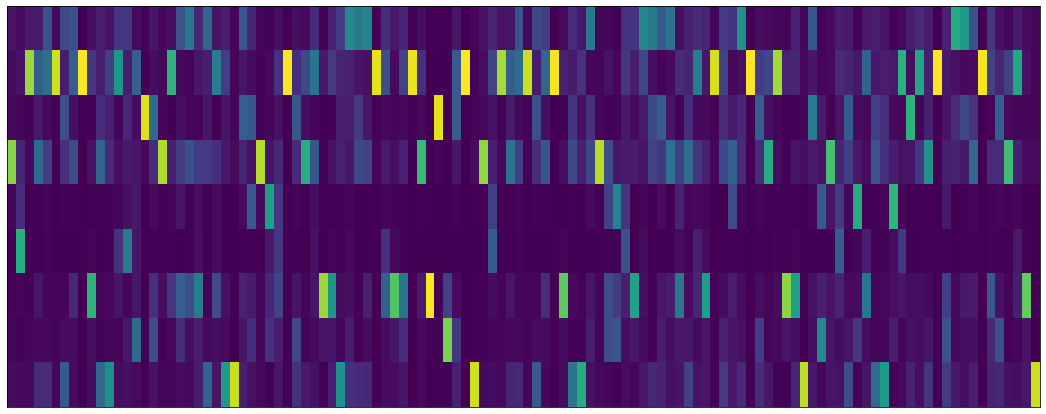

In [11]:
matrix = a[0].detach().numpy().T

fig = plt.gcf()
fig.set_size_inches(18.5, 18.5)
ax = plt.gca()
ax.matshow(matrix, aspect=5)

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.savefig("att.png", dpi=100)
plt.show()

In [12]:
print(' '.join(answer))
for i in range(len(matrix)):
    d = {}
    for j in range(len(matrix[i])):
        d[j] = matrix[i][j]
    sorted_d = sorted(d, key=d.get, reverse=True)
    print(query[i], [context[sorted_d[k]] for k in range(5)])

1995
what ['that', 'have', 'them', 'advanced', 'chance']
year ['1995', '20–18', '15–1', 'four', '49–15']
was ['was', 'was', 'as', 'they', 'named']
the ['the', 'the', 'the', 'the', 'the']
carolina ['pittsburgh', 'dallas', 'arizona', 'england', 'defeated']
panthers ['panthers', 'cam', 'patriots', 'broncos', 'patriots']
franchise ['franchise', 'championship', 'championship', 'bowl', 'record']
founded ['founded', 'joined', 'newton', 'england', 'teams']
? ['.', '.', '.', '.', 'and']
